In [1]:
%pip install torch numpy pandas scikit-learn matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


/var/folders/ff/5jrtxtbj1bz1c35lptfw2_jr0000gn/T/ipykernel_14398/975754507.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.Tensor(dataX), torch.Tensor(dataY)
/opt/homebrew/Caskroom/miniconda/base/envs/xlstm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training xLSTM: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


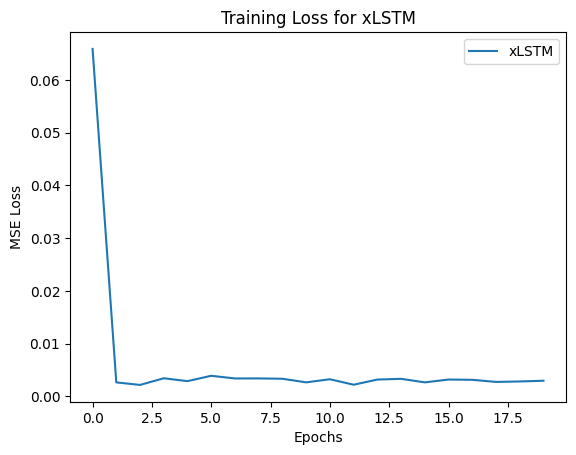

Training LSTM: 100%|██████████| 20/20 [00:00<00:00, 30.03it/s]


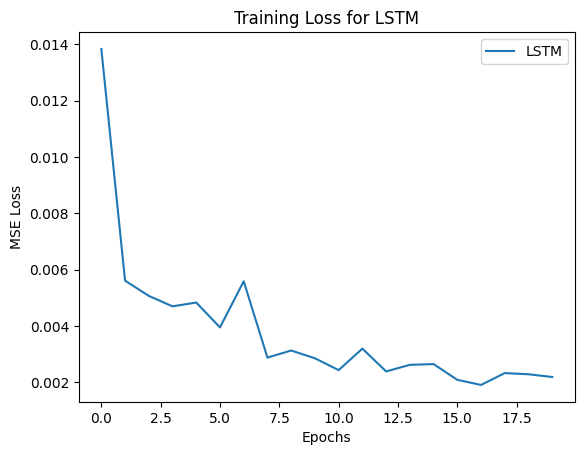

Training sLSTM: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


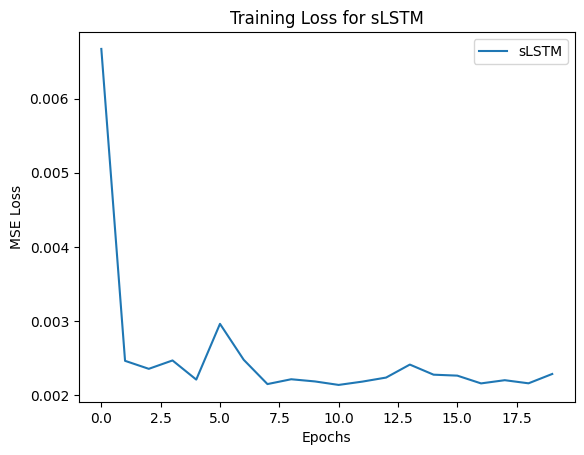

Training mLSTM: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


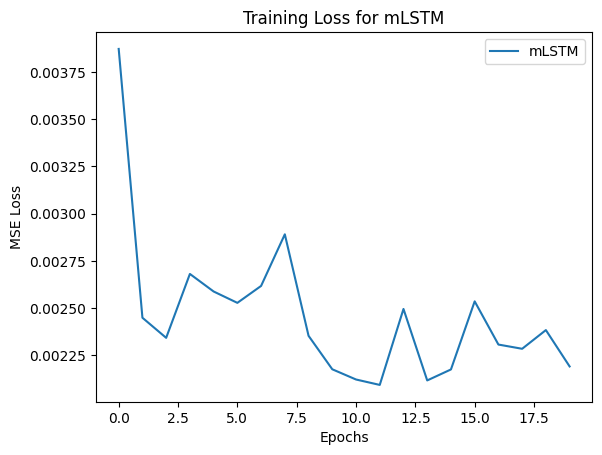

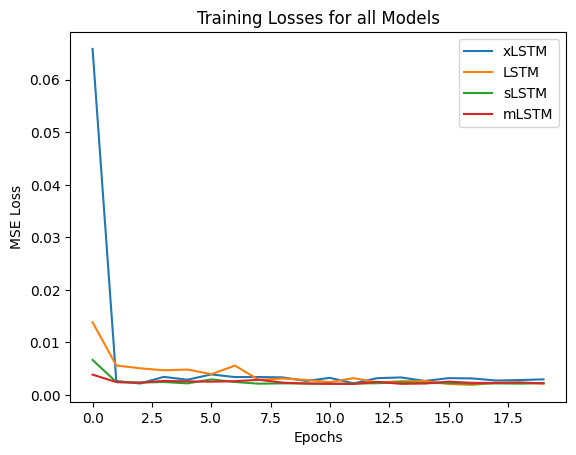

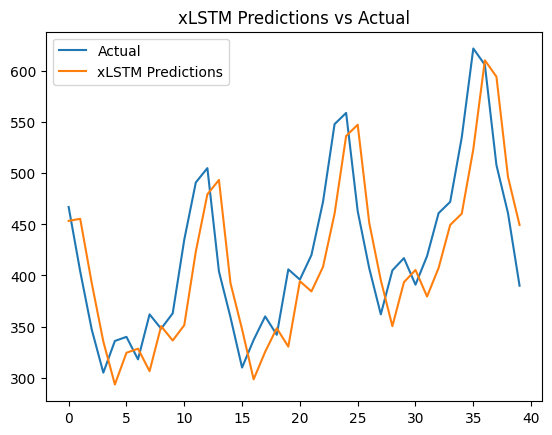

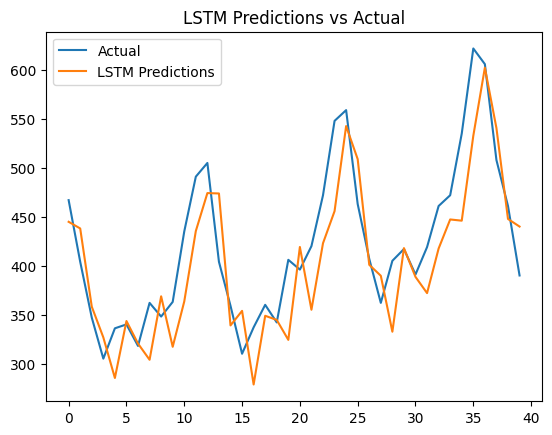

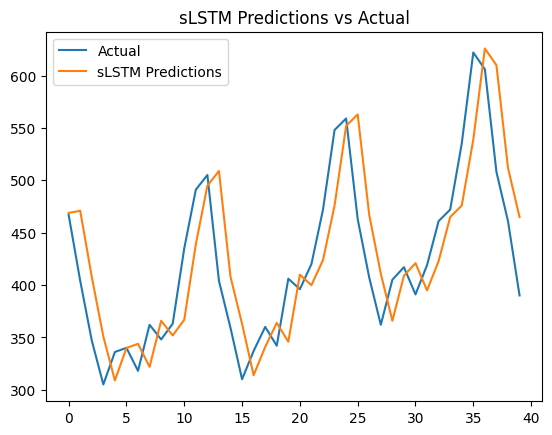

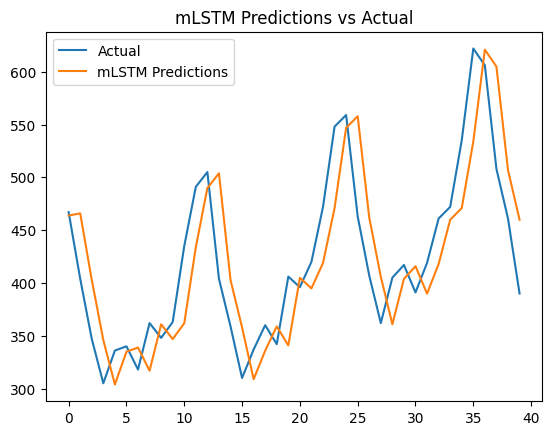

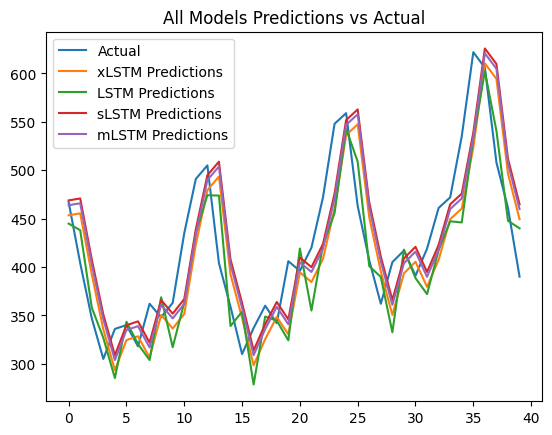

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from xlstm import sLSTM, mLSTM, xLSTM 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Dataset hyperparameters
batch_size = 3
seq_len = 8


# Load and preprocess the AirPassengers dataset
data = pd.read_csv('AirPassengers.csv', usecols=[1], engine='python')
dataset = data.values.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

def create_dataset(dataset, seq_len=8):
    dataX, dataY = [], []
    for i in range(len(dataset) - seq_len):
        a = dataset[i:(i + seq_len - 1)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len - 1])
    return torch.Tensor(dataX), torch.Tensor(dataY)

trainX, trainY = create_dataset(train, seq_len)
testX, testY = create_dataset(test, seq_len)

# Create data loaders
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Model hyperparameters
input_size = 1
hidden_size = 32
num_heads = 1


# Define models
models = {
    "xLSTM": xLSTM(input_size, hidden_size, num_heads, batch_first=True, layers='msm'),
    "LSTM": nn.LSTM(input_size, hidden_size, batch_first=True, proj_size=input_size),
    "sLSTM": sLSTM(input_size, hidden_size, num_heads, batch_first=True),
    "mLSTM": mLSTM(input_size, hidden_size, num_heads, batch_first=True)
}

# Training process
def train_model(model, model_name, epochs=20, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            outputs = outputs[:, -1, :]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

    plt.plot(train_losses, label=model_name)
    plt.title(f'Training Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    return model, train_losses

# Train the models
trained_models = {}
all_train_losses = {}
for model_name, model in models.items():
    trained_models[model_name], all_train_losses[model_name] = train_model(model, model_name)

# Plot losses for each model
plt.figure()
for model_name, train_losses in all_train_losses.items():
    plt.plot(train_losses, label=model_name)

# Plot all model losses compared
plt.title('Training Losses for all Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Evaluate models on test data
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs, _ = model(inputs)
            predictions.extend(outputs[:, -1, :].numpy())
    return predictions

test_predictions = {}
for model_name, model in trained_models.items():
    test_predictions[model_name] = evaluate_model(model, test_loader)

# Plot predictions for each model
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))

    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.legend()
    plt.show()


# Plot all model predictions compared
plt.figure()
plt.plot(actual, label='Actual')
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions 
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    plt.plot(preds, label=model_name + ' Predictions')

plt.title('All Models Predictions vs Actual')
plt.legend()
plt.show()